In [22]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import denoising
import utils
import importlib
utils = importlib.reload(utils)
plt.rcParams['text.usetex'] = True


In [23]:
method = 'double'
nu = '217'
cmb_bool = True
nu_load = (217,353)
dust, data, image_denoised = np.load(f"/Users/tsouros/Desktop/ScatteringDenoising/nu={nu_load}_cmb={cmb_bool}_cross4.npy")


In [24]:
if nu == '217' and method == 'double':
    dust = dust[0]
    data = data[0]
    image_syn = image_denoised[0]
elif nu == '353' and method == 'double':
    dust = dust[1]
    data = data[1]
    image_syn = image_denoised[1]    

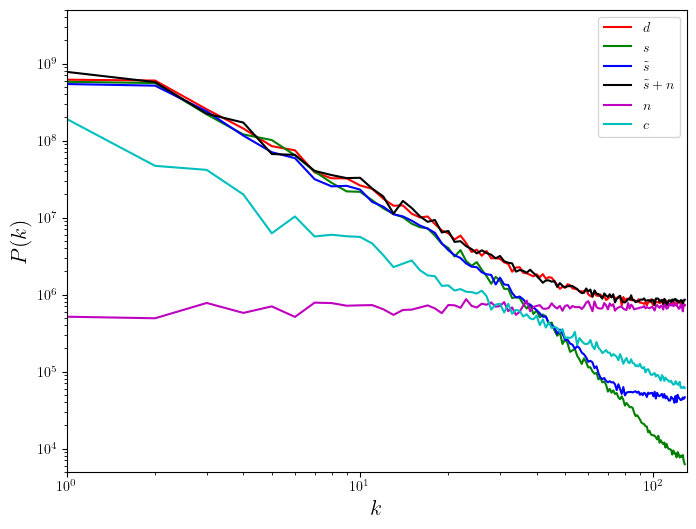

In [25]:
# Plotting all (k, bins) pairs
plt.figure(figsize=(8, 6))

variance = (np.std(dust))**2

noise = np.random.normal(0, np.sqrt(variance), dust.shape)

nx, ny = data.shape
amplitude = 2
spectral_index = -1.7

lam = 0.8
image_syn_filtered = denoising.filter_radial(np.array([image_syn]), lambda k: k < nx * lam)
image_syn_filtered = image_syn_filtered[0]

if cmb_bool == True:
    cmb = utils.generate_cmb_map(n_x=nx,n_y=ny, amplitude=amplitude, spectral_index=spectral_index)
    cmb = cmb.cpu().numpy()
    for x, name, c in zip([data,  dust, image_syn_filtered, image_syn_filtered + noise + cmb, noise, cmb], [r"$d$", r"$s$", r"$\tilde{s}$", r"$\tilde{s} + n$", r"$n$", r"$c$"], ["r", "g", "b", "k", "m", "c"]):
        k, bins = utils.power_spectrum(x)
        plt.loglog(k, bins, label=name, c=c, alpha = 1)
elif cmb_bool == False:
    for x, name, c in zip([data,  dust, image_syn_filtered, image_syn_filtered + noise, noise], [r"$d$", r"$s$", r"$\tilde{s}$", r"$\tilde{s} + n$", r"$n$"], ["r", "g", "b", "k", "m", "c"]):
        k, bins = utils.power_spectrum(x)
        plt.loglog(k, bins, label=name, c=c, alpha = 1)


plt.xlim(1e0, 1.3e2)  
plt.ylim(5e3, 5e9) 

plt.xlabel(r"$k$", fontsize=16)  # Add x-axis label with LaTeX formatting
plt.ylabel(r"$P(k)$", fontsize=16)  # Add x-axis label with LaTeX formatting
# plt.title(fr"$\nu = {nu}$ GHz, method = {method}")

plt.legend()

plt.savefig(f'PS_nu={nu}_cmb={cmb_bool}_{method}.png')

plt.show()

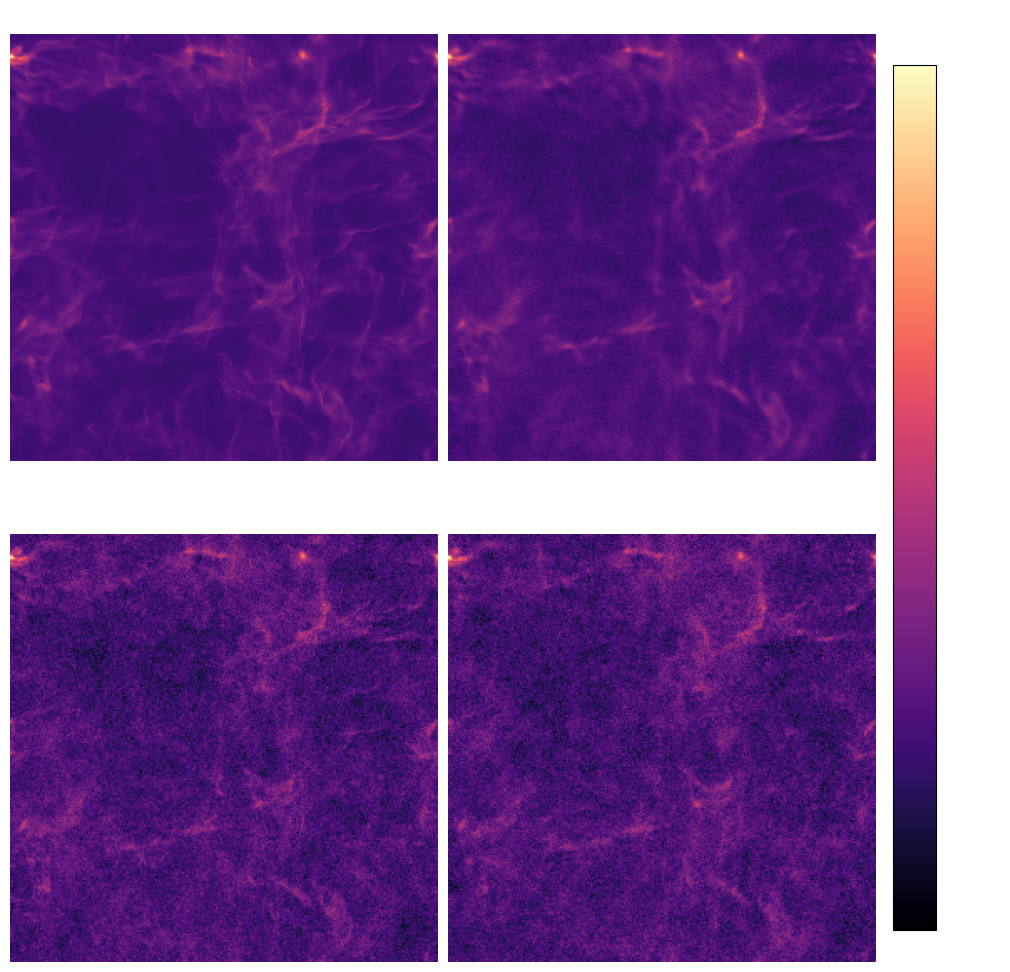

In [26]:
# Enable LaTeX rendering in Matplotlib
plt.rcParams['text.usetex'] = True

# Compute reconstructed contaminated image
if cmb_bool:
    rec_cont = image_syn + noise + cmb
else:
    rec_cont = image_syn + noise


# # Compute filtered image
image_syn_filtered = denoising.filter_radial(np.array([image_syn]), lambda k: k < nx * lam)
image_syn_filtered = image_syn_filtered[0]

# Compute global vmin and vmax for a consistent color scale
vmin = min(dust.min(), image_syn.min(), data.min(), rec_cont.min())
vmax = max(dust.max(), image_syn.max(), data.max(), rec_cont.max())


cmap = 'magma'
color = 'white'

# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)

# Set figure background to transparent
fig.patch.set_alpha(0)

# Plot each image with the same color scale
im0 = axes[0, 0].imshow(dust, cmap=cmap, vmin=vmin, vmax=vmax)
axes[0, 0].set_title(r'$s$', fontsize=16, color=color)

im1 = axes[0, 1].imshow(image_syn_filtered, cmap=cmap, vmin=vmin, vmax=vmax)
axes[0, 1].set_title(r'$\tilde{s}$', fontsize=16, color=color)

im2 = axes[1, 0].imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
axes[1, 0].set_title(r'$d$', fontsize=16, color=color)

im3 = axes[1, 1].imshow(rec_cont, cmap=cmap, vmin=vmin, vmax=vmax)
if cmb_bool:
    axes[1, 1].set_title(r'$\tilde{s} + c + n$', fontsize=16, color=color)
else:
    axes[1, 1].set_title(r'$\tilde{s} + n$', fontsize=16, color=color)


# Remove axis ticks
for ax in axes.ravel():
    ax.axis('off')

# Add a common colorbar
cbar = fig.colorbar(im3, ax=axes, orientation="vertical", fraction=0.05, pad=0.02)
cbar.set_label(r"$\mu K_{CMB}$", fontsize=20, color=color)

# Set colorbar text to white
cbar.ax.yaxis.set_tick_params(color='white')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color=color)

plt.rcParams['text.usetex'] = False  # Disable full LaTeX rendering
# fig.suptitle(fr"$\nu = {nu}$ GHz, method = {method}", fontsize=20, color=color)

plt.savefig(f'nu={nu}_cmb={cmb_bool}_{method}.png')

    
plt.show()